In [12]:
import time
import numpy as np
import pandas as pd
import glob
import subprocess as sp
import os
from matplotlib import pyplot as plt
from ellipse import LsqEllipse
import cv2
import math
import scipy.stats as stats
from tqdm import tqdm
from matplotlib.patches import Ellipse
from bokeh.plotting import figure, show

In [78]:
def oe_events_parser(open_ephys_csv_path, channel_names, export_path=None):
    """
    :param open_ephys_csv_path: The path to an open ephys analysis tools exported csv (using TrialReporter.ipynb)
    :param channel_names: a dictionary of the form -
                    { 1 : 'channel name' (L_eye_camera)
                      2 : 'channel name' (Arena_TTL)
                      etc..
                    }
    :param export_path: default None, if a path is specified a csv file will be saved
    :returns open_ephys_events: a pandas DataFrame object where each column has the ON events of one channel
                                and has a title from channel_names
    :returns open_ephys_off_events: same but for the OFF states (only important for the logical start-stop signal)
    """

    # Infer the active channels:
    df = pd.read_csv(open_ephys_csv_path)
    channels = df['channel'].to_numpy(copy=True)
    channels = np.unique(channels)
    df_onstate = df[df['state']==1] #cut the df to represent only rising edges
    df_offstate = df[df['state']==0] # This one is important for the ON/OFF signal of the arena
    list = []
    off_list= []
    for chan in channels: #extract a pandas series of the ON stats timestamps for each channel
        Sname = channel_names[chan]
        s = pd.Series(df_onstate['timestamp'][df_onstate['channel'] == chan], name=Sname)
        offs = pd.Series(df_offstate['timestamp'][df_offstate['channel'] == chan], name=Sname)
        list.append(s)
        off_list.append(offs)
    open_ephys_events = pd.concat(list, axis=1)
    open_ephys_off_events = pd.concat(off_list, axis=1)
    if export_path is not None :
        if not export_path in os.listdir(open_ephys_csv_path.split('events.csv')[0][:-1]):
            open_ephys_events.to_csv(export_path)
    return open_ephys_events , open_ephys_off_events

def convert_h264_mp4(path):
    files_to_convert = glob.glob(path + r'\**\*.h264', recursive=True)
    converted_files = glob.glob(path + r'\**\*.mp4', recursive=True)
    for file in files_to_convert:
        fps = file[file.find('hz') - 2:file.find('hz')]
        if len(fps) != 2:
            fps = 60
            print('could not determine fps, using 60...')
        if not str(fr'{file[:-5]}.mp4') in converted_files:
            sp.run(f'MP4Box -fps {fps} -add {file} {file[:-5]}.mp4')
            print(fr'{file} converted ')
        else:
            print(f'The file {file[:-5]}.mp4 already exists, no conversion necessary')

def validate_no_framedrop(path):
    videos_to_inspect = glob.glob(path + r'\**\*.mp4', recursive=True)
    timestamps_to_inspect = glob.glob(path + r'\**\*.csv', recursive=True)
    for vid in range(len(videos_to_inspect)):
        timestamps = pd.read_csv(timestamps_to_inspect[vid])
        num_reported = timestamps.shape[0]
        cap = cv2.VideoCapture(videos_to_inspect[vid])
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f'The video named {os.path.split(videos_to_inspect[vid])[1]} has reported {num_reported} frames '
              f'and has {length} frames, it has dropped {num_reported - length} frames')
        cap.release()

def stamp_diff_videos(path_to_stamp,stamp):
    videos_to_stamp = glob.glob(path_to_stamp + r'\**\*.mp4', recursive=True)
    for vid in videos_to_stamp:
        os.rename(vid, fr'{vid[:-4]}_{stamp}{vid[-4:]}')

def get_frame_timeseries(df,channel):
    index_range = range(0,len(df[channel][df[channel].notna()]))
    timeseries = pd.Series(df[channel][df[channel].notna()])
    timeseries = pd.Series(timeseries.values, index=index_range, name=channel)
    return timeseries

def get_closest_frame(timestamp, vid_timeseries, report_acc=None):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param vid_timeseries: The time frames series to look at for a match
    :param report_acc: if set to 1, will report the accuracy of the match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs((vid_timeseries.to_numpy())-timestamp)
    index_of_lowest_diff = np.argmin(array)
    if report_acc == 1:
        accuracy = abs(vid_timeseries[index_of_lowest_diff] - timestamp)
        return index_of_lowest_diff, accuracy
    else:
        return index_of_lowest_diff

def arena_video_initial_thr(vid_path, threshold_value, show_frames=False):
    """
        This function works through an arena video to determine where the LEDs are on and when off
        :param threshold_value: value of the frame threshold
        :param show_frames: if true will show the video after thresholding
        :param  vid_path: Path to video. When ShowFrames is True a projection of the frames after threshold is presented

        :return: np.array with frame numbers and mean values after threshold
        """
    cap = cv2.VideoCapture(vid_path)
    all_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    flag = 0
    i = 0
    mean_values = []
    indexes = []
    while flag == 0:
        print('Frame number {} of {}'.format(i, all_frames), end='\r', flush=True)
        ret, frame = cap.read()
        if not ret:
            break
        grey = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        grey[grey < threshold_value] = 0
        mean_values.append(np.mean(grey))
        indexes.append(i)
        if show_frames:
            cv2.imshow('Thresholded_Frames', grey)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        i += 1
    cap.release()
    cv2.destroyAllWindows()
    frame_val = np.array((indexes, mean_values))
    return frame_val

def produce_frame_val_list(vid_paths,threshold_value):
    """
    :param vid_paths: a list of str paths to videos for analysis
    :param threshold_value: the threshold to use in order to concentrate on LEDs
    :return: frame_val_list: a list of mean pixel values for each frame after threshold
    """
    frame_val_list = []
    for vid in vid_paths:
        print(f'working on video {vid}')
        frame_val = arena_video_initial_thr(vid, threshold_value)
        frame_val_list.append(frame_val)
    print(f'done, frame_val_list contains {len(frame_val_list)} objects',flush=True)

    return frame_val_list

def four_video_concat(output_name, vid1, vid2, vid3, vid4,  start_frame, shortest_vid_length, format='H264'):
    """
    :param vid1: left down
    :param vid2: right down
    :param vid3: left up
    :param vid4: right up
    :param shortest_vid_length:
    :param output_name: output file name
    :return: a concatenated video of the 4 inputs
    """
    cap0 = cv2.VideoCapture(vid1)
    cap1 = cv2.VideoCapture(vid2)
    cap2 = cv2.VideoCapture(vid3)
    cap3 = cv2.VideoCapture(vid4)
    anchor = start_frame
    last_ar_f = sync_vids.Arena_VideoFrame[start_frame]
    last_le = sync_vids.Left_eye[start_frame]
    last_re = sync_vids.Right_eye[start_frame]
    fourcc = cv2.VideoWriter_fourcc(*format)
    out = cv2.VideoWriter((path + r'\\' + output_name + '.mp4'),fourcc, 60.0, (640*2,480*2))
    try:
        while cap2.isOpened():
            ar_f = sync_vids.Arena_VideoFrame[anchor]
            l_eye_f = sync_vids.Left_eye[anchor]
            r_eye_f = sync_vids.Right_eye[anchor]

            if ar_f != last_ar_f + 1:
                cap0.set(1,ar_f)
            ar_ret0, ar_frame0 = cap0.read()
            ar_frame0 = cv2.cvtColor(ar_frame0, cv2.COLOR_BGR2GRAY)
            ar_frame0 = cv2.resize(ar_frame0,(640,480))
            last_ar_f = ar_f

            if ar_f != last_ar_f + 1:
                cap1.set(1,ar_f)
            ar_ret, ar_frame = cap1.read()
            ar_frame = cv2.cvtColor(ar_frame, cv2.COLOR_BGR2GRAY)
            ar_frame = cv2.resize(ar_frame,(640,480))

            if l_eye_f != last_le + 1:
                cap2.set(1,l_eye_f)
            le_ret, le_f = cap2.read()
            le_f = cv2.cvtColor(le_f, cv2.COLOR_BGR2GRAY)
            le_f = cv2.flip(le_f, 0)
            le_f = cv2.resize(le_f,(640,480))
            last_le = l_eye_f

            if r_eye_f != last_re + 1:
                cap3.set(1,r_eye_f)
            re_ret, re_f = cap3.read()
            re_f = cv2.cvtColor(re_f, cv2.COLOR_BGR2GRAY)
            re_f = cv2.flip(re_f, 0)
            re_f = cv2.resize(re_f,(640,480))
            last_re = r_eye_f

            eye_concat = np.hstack((le_f,re_f))
            ar_concat = np.hstack((ar_frame0, ar_frame))
            vconcat = np.vstack((eye_concat, ar_concat))

            out.write(vconcat)
            anchor += 1
            print(f'writing video frame {anchor} out of {shortest_vid_length}', end='\r', flush=True)
            if anchor > shortest_vid_length-1:
                break
    except Exception:
        print(f'Encountered a problem with frame {anchor}, stopping concatenation')
    finally:
        cap0.release()
        cap1.release()
        cap2.release()
        cap3.release()
        out.release()
        cv2.destroyAllWindows()
        print('\n')
        print('Processed finished')

def eye_tracking_analysis(dlc_video_analysis_csv):
    """
    :param dlc_video_analysis_csv: the csv output of a dlc analysis of one video, already read by pandas with header=1
    :param bodyparts_list: a list of bodyparts as described in the dlc csv (i.e ['Pupil_12', 'Pupil_6'....])
    :returns ellipse_df: a DataFrame of ellipses parameters (center, width, height, phi, size) for each video frame
    """

    data = dlc_video_analysis_csv
    ellipses = []
    caudal_edge_ls= []
    rostral_edge_ls = []
    for row in range(1, len(data)-1):
        x_values = np.array(list([float(data['Pupil_12'][row]),
                                  float(data['Pupil_1'][row]),
                                  float(data['Pupil_3'][row]),
                                  float(data['Pupil_4'][row]),
                                  float(data['Pupil_6'][row]),
                                  float(data['Pupil_8'][row]),
                                  float(data['Pupil_10'][row])]))
        y_values = np.array(list([float(data['Pupil_12.1'][row]),
                                  float(data['Pupil_1.1'][row]),
                                  float(data['Pupil_3.1'][row]),
                                  float(data['Pupil_4.1'][row]),
                                  float(data['Pupil_6.1'][row]),
                                  float(data['Pupil_8.1'][row]),
                                  float(data['Pupil_10.1'][row])]))
        X = np.c_[x_values,y_values]

        el = LsqEllipse().fit(X)
        center, width, height, phi = el.as_parameters()
        center_x = center[0]
        center_y = center[1]
        ellipses.append([center_x,center_y,width,height,phi])
        caudal_edge = [
            float(data['Caudal_edge'][row]),
            float(data['Caudal_edge.1'][row])
        ]
        rostral_edge = [
            float(data['Rostral_edge'][row]),
            float(data['Rostral_edge.1'][row])
        ]
        caudal_edge_ls.append(caudal_edge)
        rostral_edge_ls.append(rostral_edge)
        if row % 50 == 0:
           print(f'just finished with {row} out of {len(data)-1}', end='\r',flush=True)
    ellipse_df = pd.DataFrame(columns = ['center_x','center_y', 'width', 'height', 'phi'], data = ellipses)
    a = np.array(ellipse_df['height'][:])
    b = np.array(ellipse_df['width'][:])
    ellipse_size_per_frame = a*b*math.pi
    ellipse_df['ellipse_size'] = ellipse_size_per_frame
    ellipse_df['rostral_edge'] = rostral_edge_ls
    ellipse_df['caudal_edge'] = caudal_edge_ls
    print('Done')
    return ellipse_df

def eye_tracking_analysis_v2(dlc_video_analysis_csv,uncertainty_thr):
    """
    :param dlc_video_analysis_csv: the csv output of a dlc analysis of one video, already read by pandas with header=1
    :param uncertainty_thr: The confidence P value to use as a threshold for datapoint validity in the analysis
    :returns ellipse_df: a DataFrame of ellipses parameters (center, width, height, phi, size) for each video frame

    """
# import the dataframe and convert it to floats
    data = dlc_video_analysis_csv
    data = data.iloc[1:].apply(pd.to_numeric)
# sort the pupil elements to x and y, with p as probability
    pupil_elements = np.array([x for x in data.columns if 'Pupil' in x])
    pupil_xs = data[pupil_elements[np.arange(0,len(pupil_elements),3)]]
    pupil_ys = data[pupil_elements[np.arange(1,len(pupil_elements),3)]]
    pupil_ps = data[pupil_elements[np.arange(2,len(pupil_elements),3)]]
    #rename dataframes for masking with p values of bad points:
    pupil_ps = pupil_ps.rename(columns=dict(zip(pupil_ps.columns,pupil_xs.columns)))
    pupil_ys = pupil_ys.rename(columns=dict(zip(pupil_ys.columns,pupil_xs.columns)))
    good_points = pupil_ps > uncertainty_thr
    pupil_xs = pupil_xs[good_points]
    pupil_ys = pupil_ys[good_points]
    #Do the same for the edges
    #edge_elements = [x for x in data.columns if 'edge' in x]
    #edge_xs = data[edge_elements[np.arange(0,len(edge_elements),3)]]
    #edge_ys = data[edge_elements[np.arange(1,len(edge_elements),3)]]
    #edge_ps = data[edge_elements[np.arange(2,len(edge_elements),3)]]
    #edge_ps = edge_ps.rename(columns=dict(zip(edge_ps.columns,edge_xs.columns)))
    #edge_ys = edge_ys.rename(columns=dict(zip(edge_ys.columns,edge_xs.columns)))
    #e = edge_ps < uncertainty_thr


    #work row by row to figure out the ellipses
    ellipses = []
    caudal_edge_ls= []
    rostral_edge_ls = []
    for row in tqdm(range(1, len(data)-1)):
        #first, take all of the values, and concatenate them into an X array
        x_values = pupil_xs.loc[row].values
        y_values = pupil_ys.loc[row].values
        X = np.c_[x_values,y_values]
        #now, remove nan values, and check if there are enough points to make the ellipse
        X = X[~ np.isnan(X).any(axis=1)]
        #if there are enough rows for a fit, make an ellipse
        if X.shape[0] > 5:
            el = LsqEllipse().fit(X)
            center, width, height, phi = el.as_parameters()
            center_x = center[0]
            center_y = center[1]
            ellipses.append([center_x,center_y,width,height,phi])
        else:
            ellipses.append([np.nan, np.nan, np.nan, np.nan, np.nan])
        # caudal_edge = [
        #     float(data['Caudal_edge'][row]),
        #     float(data['Caudal_edge.1'][row])
        # ]
        # rostral_edge = [
        #     float(data['Rostral_edge'][row]),
        #     float(data['Rostral_edge.1'][row])
        # ]
        # caudal_edge_ls.append(caudal_edge)
        # rostral_edge_ls.append(rostral_edge)
        #if row % 50 == 0:
        #   print(f'just finished with {row} out of {len(data)-1}', end='\r',flush=True)
    ellipse_df = pd.DataFrame(columns = ['center_x','center_y', 'width', 'height', 'phi'], data = ellipses)
    a = np.array(ellipse_df['height'][:])
    b = np.array(ellipse_df['width'][:])
    ellipse_size_per_frame = a*b*math.pi
    ellipse_df['ellipse_size'] = ellipse_size_per_frame
    #ellipse_df['rostral_edge'] = rostral_edge_ls
    #ellipse_df['caudal_edge'] = caudal_edge_ls
    print('\n Done')
    return ellipse_df

In [ ]:
"""
This notebook should be the main sequence for incoming experimental data - there are prerequisites for a functional process:
- the process is designed to work block-by-block
- Data will be arranged into block folders under animal folders, where each block contains the next structure:

                                       /----> arena_videos  ->[config.yaml , info.yaml] videos -> [video files, output.log] timestamps -> [csv of timestamps]

Animal_x ->date(xx_xx_xxxx) -> block_x -----> eye_videos >> LE\RE -> video folder with name -> [video.h264 , video.mp4 , params.json , timestamps.csv]

                                       \----> oe_files >> date_time(xxxx_xx_xx_xx-xx-xx) --> [events.csv] internal open ephys structure from here (NWB format only!!!)
                                                                                             /////////////////////
                                                                                         TODO: internal parsing of this file
"""

In [14]:
animal_number = '0'
experiment_date = '24_03_2021'
block = '5'
path = rf'D:\experiments\Animal_{animal_number}\{experiment_date}\block_{block}'
print(path)
#Arena
arvid_path = path + r'\arena_videos\videos\*.mp4'
arena_videos = glob.glob(path + r'\arena_videos\videos\*.mp4')
print(arena_videos)


D:\experiments\Animal_0\24_03_2021\block_5
['D:\\experiments\\Animal_0\\24_03_2021\\block_5\\arena_videos\\videos\\back_20210324T122209.mp4', 'D:\\experiments\\Animal_0\\24_03_2021\\block_5\\arena_videos\\videos\\left_20210324T122209.mp4', 'D:\\experiments\\Animal_0\\24_03_2021\\block_5\\arena_videos\\videos\\realtime_20210324T122209.mp4', 'D:\\experiments\\Animal_0\\24_03_2021\\block_5\\arena_videos\\videos\\stream_20210324T122209.mp4']


In [15]:
ar_vidnames = []
for vid in arena_videos:
    vidname = vid.split(sep="\\") ; vidname = vidname[len(vidname)-1]
    vidname=vidname.split(sep='.') ; vidname=vidname[0]
    ar_vidnames.append(vidname)
print(ar_vidnames)

['back_20210324T122209', 'left_20210324T122209', 'realtime_20210324T122209', 'stream_20210324T122209']


In [ ]:
vid_path = path + r'\eye_videos'
print('converting videos...')
convert_h264_mp4(vid_path)
print('Validating videos...')
validate_no_framedrop(vid_path)

In [ ]:
print('stamping LE video')
stamp_diff_videos(vid_path+r'\LE' , 'LE')

In [16]:
le_video = glob.glob(path + r'\eye_videos\LE\**\*.mp4')
re_video = glob.glob(path + r'\eye_videos\RE\**\*.mp4')

In [17]:
channeldict = {
    5 : 'L_eye_TTL',
    6 : 'Arena_TTL',
    7 : 'Logical ON/OFF',
    8 : 'R_eye_TTL'
}
exp_date_time = os.listdir(fr'{path}\oe_files')[0]
oe_events , oe_off_events = oe_events_parser(path + rf'\oe_files\{exp_date_time}\events.csv',
                                             channeldict,
                                             export_path=path + rf'\oe_files\{exp_date_time}\parsed_events.csv')
ts_list = []
for chan in list(oe_events.columns):
    ts = get_frame_timeseries(oe_events,str(chan))
    ts_list.append(ts)
logical_off_series = get_frame_timeseries(oe_off_events,'Logical ON/OFF')
block_start_time = ts_list[2].values[0]
del ts_list[2]
block_end_time = logical_off_series.values[0]

In [18]:
print(f'Arena video start: {block_start_time} \n'
      f'Arena video end: {block_end_time} \n'
      f'Block length: {block_end_time - block_start_time} Seconds')

Arena video start: 4.237100124359132 
Arena video end: 534.8704223632811 
Block length: 530.633322238922 Seconds


In [19]:
#Arena
arena_ff = ts_list[1].values[ts_list[1]>block_start_time][0]
arena_first_index = ts_list[1][ts_list[1] == arena_ff].index
arena_lf = ts_list[1].values[ts_list[1]<block_end_time][-1]
arena_last_index = ts_list[1][ts_list[1] == arena_lf].index
arena_sync_s = pd.Series(ts_list[1][arena_first_index.asi8[0] : arena_last_index.asi8[0]])

#Left eye
le_ff = ts_list[0].values[0]
le_first_index = ts_list[0][ts_list[0] == le_ff].index
le_lf = ts_list[0].values[-1]
le_last_index = ts_list[0][ts_list[0] == le_lf].index
le_sync_s = ts_list[0]

#Right eye
re_ff = ts_list[2].values[0]
re_first_index = ts_list[2][ts_list[2] == re_ff].index
re_lf = ts_list[2].values[-1]
re_last_index = ts_list[2][ts_list[2] == re_lf].index
re_sync_s = ts_list[2]

sync_time_starts = max([arena_ff, le_ff, re_ff])
sync_time_ends = min([arena_lf, le_lf, re_lf])

In [40]:
#Define Anchor signal
anchor_signal = np.arange(sync_time_starts, sync_time_ends, 1/60)

#Create the DataFrame
sync_vids = pd.DataFrame(data=None,
                         index=range(len(anchor_signal)),
                         columns=['Left_eye','Arena','Arena_VideoFrame','Right_eye'])

accuracy_report = pd.DataFrame(data=None,
                               index=range(len(anchor_signal)),
                               columns=['Left_eye','Arena','Right_eye'])

# define dictionary for timestamp retrieval
ts_dict = {'Left_eye': ts_list[0],
           'Arena': ts_list[1],
           'Right_eye':ts_list[2]}

#Iterate over the length of the dataframe and fit
for frame in range(len(anchor_signal)):
    anchor_time = anchor_signal[frame]
    if frame % 50 == 0:
        print(f'frame {frame} out of {len(anchor_signal)}', end='\r', flush=True)
    for vid in ['Left_eye', 'Right_eye', 'Arena']:
        f,a = get_closest_frame(anchor_time, ts_dict[vid], report_acc=1)
        sync_vids[vid][frame] = f
        accuracy_report[vid][frame] = a

In [60]:
sync_vids.Arena_VideoFrame = sync_vids.Arena - (arena_first_index.asi8[0] + 62)
sync_vids.Left_eye = sync_vids.Left_eye
sync_vids

,Left_eye,Arena,Arena_VideoFrame,Right_eye
0,4,917,606,2
1,5,918,607,3
2,6,919,608,4
3,7,920,609,5
4,8,921,610,6
...,...,...,...,...
31052,31113,31319,31008,31111
31053,31113,31320,31009,31112
31054,31114,31321,31010,31113
31055,31116,31322,31011,31114


In [22]:
arena_frame_val_list = produce_frame_val_list(arena_videos,250)

working on video D:\experiments\Animal_0\24_03_2021\block_5\arena_videos\videos\back_20210324T122209.mp4
working on video D:\experiments\Animal_0\24_03_2021\block_5\arena_videos\videos\left_20210324T122209.mp4
working on video D:\experiments\Animal_0\24_03_2021\block_5\arena_videos\videos\realtime_20210324T122209.mp4
working on video D:\experiments\Animal_0\24_03_2021\block_5\arena_videos\videos\stream_20210324T122209.mp4
done, frame_val_list contains 4 objects


In [23]:
l_eye_frame_val_list = produce_frame_val_list(le_video, 30)
r_eye_frame_val_list = produce_frame_val_list(re_video,30)

working on video D:\experiments\Animal_0\24_03_2021\block_5\eye_videos\LE\hangingwormpluslandscapes6min_1_640x480_60hz_experiment_1_recording_0\hangingwormpluslandscapes6min_1_LE.mp4
working on video D:\experiments\Animal_0\24_03_2021\block_5\eye_videos\LE\hangingwormpluslandscapes6min_1_640x480_60hz_experiment_1_recording_0\hangingwormpluslandscapes6min_1_LEDLC_resnet_50_Eye_Tracking_piplineMar1shuffle1_900000_labeled.mp4
done, frame_val_list contains 2 objects
working on video D:\experiments\Animal_0\24_03_2021\block_5\eye_videos\RE\hangingwormpluslandscapes6min_1_640x480_60hz_experiment_1_recording_0\hangingwormpluslandscapes6min_1.mp4
working on video D:\experiments\Animal_0\24_03_2021\block_5\eye_videos\RE\hangingwormpluslandscapes6min_1_640x480_60hz_experiment_1_recording_0\hangingwormpluslandscapes6min_1DLC_resnet_50_Eye_Tracking_piplineMar1shuffle1_900000_labeled.mp4
done, frame_val_list contains 2 objects


In [28]:
l_eye_values = stats.zscore(l_eye_frame_val_list[0][1])
r_eye_values = stats.zscore(r_eye_frame_val_list[0][1])

In [ ]:
sync_vids.Left_eye.values.astype(int)

In [61]:
arena_brightness_df = pd.DataFrame(index = anchor_signal)
for ind, vid in enumerate(ar_vidnames):
    vid_val_arr = stats.zscore(arena_frame_val_list[ind][1])
    sync_list = sync_vids.Arena_VideoFrame.astype(int)
    sync_list[sync_list >= len(vid_val_arr)] = len(vid_val_arr)-1
    arena_brightness_df.insert(loc=0,
                               column=str(vid),
                               value=vid_val_arr[sync_list])

In [62]:
eye_brightness_df = pd.DataFrame(index=anchor_signal)
eye_brightness_df.insert(loc=0,
                         column='left_eye',
                         value=l_eye_values[sync_vids.Left_eye.values.astype(int)[0:len(anchor_signal)]])
eye_brightness_df.insert(loc=0,
                         column='right_eye',
                         value=r_eye_values[sync_vids.Right_eye.values.astype(int)[0:len(anchor_signal)]])

In [63]:
arena_brightness_df

,stream_20210324T122209,realtime_20210324T122209,left_20210324T122209,back_20210324T122209
17.247700,-0.771456,2.644457,0.473667,-0.423636
17.264366,-0.741209,2.560887,0.303350,-0.538187
17.281033,-0.852165,2.614906,0.471573,-0.424006
17.297700,-0.852165,2.539067,0.369007,-0.424006
17.314366,-0.852773,2.560887,0.303350,-0.538187
...,...,...,...,...
534.781033,-0.385390,0.103968,0.217108,-0.516339
534.797700,-0.385390,0.103968,0.217108,-0.516339
534.814366,-0.385390,0.103968,0.217108,-0.516339
534.831033,-0.385390,0.103968,0.217108,-0.516339


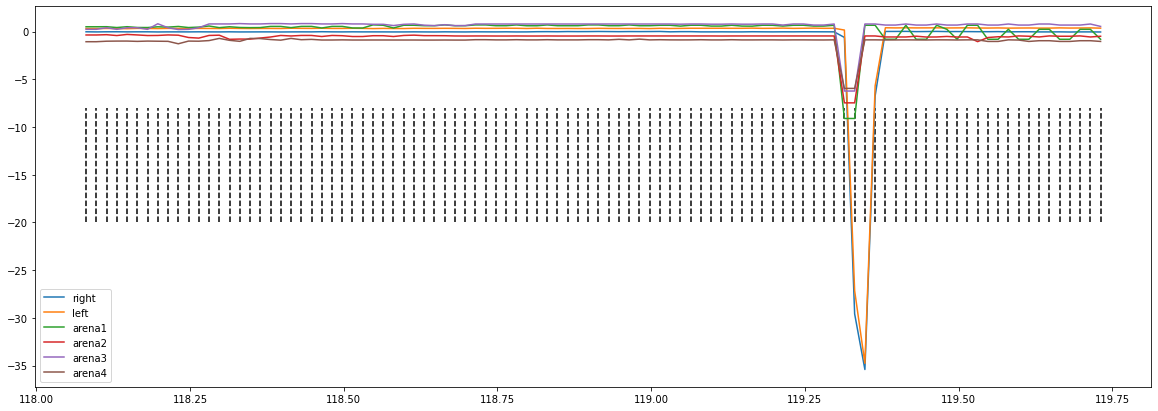

In [73]:

sec = 3600
x = 1
region = range(2450+x*sec, 2550+x*sec)

plt.figure(figsize=[20,7])
plt.plot(eye_brightness_df.iloc[region].index, eye_brightness_df.iloc[region].right_eye, label='right')
plt.plot(eye_brightness_df.iloc[region].index, eye_brightness_df.iloc[region].left_eye, label='left')
plt.plot(eye_brightness_df.iloc[region].index, arena_brightness_df.iloc[region]['stream_20210324T122209'], label='arena1')
plt.plot(eye_brightness_df.iloc[region].index, arena_brightness_df.iloc[region]['realtime_20210324T122209'], label='arena2')
plt.plot(eye_brightness_df.iloc[region].index, arena_brightness_df.iloc[region]['left_20210324T122209'], label='arena3')
plt.plot(eye_brightness_df.iloc[region].index, arena_brightness_df.iloc[region]['back_20210324T122209'], label='arena4')
plt.vlines(eye_brightness_df.iloc[region].index, -20, -8, linestyles={'dashed'})
plt.legend()


In [74]:
sync_vids_validated = sync_vids
sync_vids_validated.insert(loc=0, column='Time', value=anchor_signal)
sync_vids_validated

,Time,Left_eye,Arena,Arena_VideoFrame,Right_eye
0,17.247700,4,917,606,2
1,17.264366,5,918,607,3
2,17.281033,6,919,608,4
3,17.297700,7,920,609,5
4,17.314366,8,921,610,6
...,...,...,...,...,...
31052,534.781033,31113,31319,31008,31111
31053,534.797700,31113,31320,31009,31112
31054,534.814366,31114,31321,31010,31113
31055,534.831033,31116,31322,31011,31114


In [75]:
sync_vids_validated.to_csv(path+r'\\vid_source_synchronization.csv')
print(rf'created {path}\vid_source_synchronization.csv')

created D:\experiments\Animal_0\24_03_2021\block_5\vid_source_synchronization.csv


In [ ]:
four_video_concat('block_9_synchronization',arena_videos[1],arena_videos[3],le_video[0],re_video[0],10,24900)


##### PHASE 2 #####

In [79]:
le_csv = pd.read_csv(glob.glob(path + r'\eye_videos\LE\**\*DLC*.csv')[0],header=1)

re_csv = pd.read_csv(glob.glob(path + r'\eye_videos\RE\**\*DLC*.csv')[0],header=1)

In [80]:
le_ellipses = eye_tracking_analysis_v2(le_csv, 0.999)
print('\n')
re_ellipses = eye_tracking_analysis_v2(re_csv, 0.999)

100%|██████████| 31302/31302 [00:14<00:00, 2089.12it/s]



 Done



 Done


In [82]:
video_sync_df = pd.read_csv(path + r'\\vid_source_synchronization.csv')
video_sync_df = video_sync_df.drop(labels=['Unnamed: 0','Arena'],axis=1)

In [83]:
le_video_sync_df = video_sync_df.drop(labels=['Arena_VideoFrame','Right_eye'],axis=1)
for column in list(le_ellipses.columns):
    le_video_sync_df.insert(loc=len(le_video_sync_df.columns), column=column, value=None)
re_video_sync_df = video_sync_df.drop(labels=['Arena_VideoFrame','Left_eye'],axis=1)
for column in list(re_ellipses.columns):
    re_video_sync_df.insert(loc=len(re_video_sync_df.columns), column=column, value=None)

In [84]:
print('populating le_video_sync_df')
for row in tqdm(le_video_sync_df.index):
    frame = le_video_sync_df.Left_eye[row]
    le_video_sync_df.loc[row, 'center_x'] = le_ellipses.iloc[frame]['center_x']
    le_video_sync_df.loc[row, 'center_y'] = le_ellipses.iloc[frame]['center_y']
    le_video_sync_df.loc[row, 'width']= le_ellipses.width[frame]
    le_video_sync_df.loc[row, 'height'] = le_ellipses.height[frame]
    le_video_sync_df.loc[row, 'phi'] = le_ellipses.phi[frame]
    le_video_sync_df.loc[row, 'ellipse_size'] = le_ellipses.ellipse_size[frame]
    #le_video_sync_df.at[row, 'rostral_edge'] = le_ellipses.rostral_edge[frame]
    #le_video_sync_df.at[row, 'caudal_edge'] = le_ellipses.caudal_edge[frame]

100%|██████████| 31057/31057 [01:43<00:00, 299.55it/s]


populating le_video_sync_df


In [85]:
print('populating re_video_sync_df')
for row in tqdm(re_video_sync_df.index):
    frame = re_video_sync_df.Right_eye[row]
    re_video_sync_df.loc[row, 'center_x'] = re_ellipses.iloc[frame]['center_x']
    re_video_sync_df.loc[row, 'center_y'] = re_ellipses.iloc[frame]['center_y']
    re_video_sync_df.loc[row, 'width']= re_ellipses.width[frame]
    re_video_sync_df.loc[row, 'height'] = re_ellipses.height[frame]
    re_video_sync_df.loc[row, 'phi'] = re_ellipses.phi[frame]
    re_video_sync_df.loc[row, 'ellipse_size'] = re_ellipses.ellipse_size[frame]
    #re_video_sync_df.at[row, 'rostral_edge'] = re_ellipses.rostral_edge[frame]
    #re_video_sync_df.at[row, 'caudal_edge'] = re_ellipses.caudal_edge[frame]

100%|██████████| 31057/31057 [01:35<00:00, 325.81it/s]


populating re_video_sync_df


In [86]:
first_frame_time = le_video_sync_df.Time.values[0]
first_frame_time

17.247699737548828

In [ ]:
fpm = 3600
x = 0
region = range(0+x*fpm, 3600+x*fpm)


In [ ]:
fig = plt.figure(figsize=[10,10])
fig.set_facecolor('xkcd:white')
plt.title('pupil location',fontsize=20)
plt.xlabel('pupil position X',fontsize=20)
plt.ylabel('Pupil position Y',fontsize=20)
plt.scatter(le_video_sync_df.center_x[region],
            le_video_sync_df.center_y[region],
            c=le_video_sync_df.Time[region] - first_frame_time,
            cmap='inferno',
            alpha=0.5,
            label='Left eye')
plt.colorbar()
#_ = plt.scatter(re_video_sync_df.center_x[region],re_video_sync_df.center_y[region],
            # label='Right eye',
            # c=re_video_sync_df.Time[region],
            # cmap='jet',
            # alpha=0.5)
plt.xlim(400,500)
plt.ylim(80,180)

In [ ]:
pupil_distance_p = (le_video_sync_df.center_x - re_video_sync_df.center_x)**2 + \
                 (le_video_sync_df.center_y - re_video_sync_df.center_y)**2
pupil_convergence = []
for val in pupil_distance_p.values:
    pupil_convergence.append(math.sqrt(val))


In [ ]:
fig = plt.figure(figsize=[20,7])
fig.set_facecolor('xkcd:white')
plt.title('pupil convergence',fontsize=20)
plt.ylabel('Convergence Z Score', fontsize=20)
plt.plot(le_video_sync_df.Time[region] - first_frame_time, stats.zscore(np.array(pupil_convergence)[region]))
_ = plt.ylim(-4,2)

In [ ]:
le_ellipses_z = (le_video_sync_df.ellipse_size - le_video_sync_df.ellipse_size.mean()) / le_video_sync_df.ellipse_size.std()
re_ellipses_z = (re_video_sync_df.ellipse_size - re_video_sync_df.ellipse_size.mean()) / re_video_sync_df.ellipse_size.std()
fig = plt.figure(figsize=[20,7])
fig.set_facecolor('xkcd:white')
plt.title('pupil_size',fontsize=20)
plt.xlabel('Time (sec)',fontsize=20)
plt.ylabel('Pupil diameter (std)',fontsize=20)
plt.plot(le_video_sync_df.Time[region] - first_frame_time, le_ellipses_z[region],label='Left Eye')
plt.plot(re_video_sync_df.Time[region] - first_frame_time, re_ellipses_z[region],label='Right Eye')

#plt.xticks(np.arange(min(le_video_sync_df.Time[region] - first_frame_time), max(le_video_sync_df.Time[region])+1))
#plt.ylim(-0.3,0.3)
_=plt.legend(fontsize=20)

In [ ]:
#pos_y_z = (le_video_sync_df.ellipse_size - le_video_sync_df.center_y.mean()) / le_video_sync_df.center_y.std()
#pos_y_z = (le_video_sync_df.ellipse_size - le_video_sync_df.center_x.mean()) / le_video_sync_df.center_x.std()
fig = plt.figure(figsize=[20,7])
fig.set_facecolor('xkcd:white')
plt.title('pupil position X',fontsize=20)
plt.xlabel('Time (sec)',fontsize=20)
plt.ylabel('Pupil position (pix)',fontsize=20)
plt.plot(le_video_sync_df.Time[region] - first_frame_time, le_video_sync_df.center_x[region],label='Left Eye X')
plt.plot(le_video_sync_df.Time[region] - first_frame_time, le_video_sync_df.center_y[region],label='Left Eye Y')
#ync_df.Time[region] - first_frame_time, re_ellipses_z[region],label='Right Eye')
#plt.xticks(np.arange(min(le_video_sync_df.Time[region] - first_frame_time), max(le_video_sync_df.Time[region])+1,0.5))
#plt.ylim(-0.3,0.3)
_=plt.legend(fontsize=20)
#this is a change to the file

In [ ]:
uncertainty_thr = 0.99999
data = le_csv
data = data.iloc[1:].apply(pd.to_numeric)
pupil_elements = np.array([x for x in data.columns if 'Pupil' in x])
pupil_xs = data[pupil_elements[np.arange(0,len(pupil_elements),3)]]
pupil_ys = data[pupil_elements[np.arange(1,len(pupil_elements),3)]]
pupil_ps = data[pupil_elements[np.arange(2,len(pupil_elements),3)]]
pupil_ps = pupil_ps.rename(columns=dict(zip(pupil_ps.columns,pupil_xs.columns)))
pupil_ys = pupil_ys.rename(columns=dict(zip(pupil_ys.columns,pupil_xs.columns)))
p = pupil_ps > uncertainty_thr
p.sum
pupil_xs = pupil_xs[p]
pupil_ys = pupil_ys[p]
row = 26295
x_values = pupil_xs.loc[row].values
y_values = pupil_ys.loc[row].values
X = np.c_[x_values,y_values]

X = X[~ np.isnan(X).any(axis=1)]
X.shape

In [ ]:
sum(data['Rostral_edge.2'] > 0.999) == len(data['Rostral_edge.2'])

In [ ]:
def eye_tracking_analysis_v2(dlc_video_analysis_csv,uncertainty_thr):
    """
    :param dlc_video_analysis_csv: the csv output of a dlc analysis of one video, already read by pandas with header=1
    :param uncertainty_thr: The confidence P value to use as a threshold for datapoint validity in the analysis
    :returns ellipse_df: a DataFrame of ellipses parameters (center, width, height, phi, size) for each video frame

    """
# import the dataframe and convert it to floats
    data = dlc_video_analysis_csv
    data = data.iloc[1:].apply(pd.to_numeric)
# sort the pupil elements to x and y, with p as probability
    pupil_elements = np.array([x for x in data.columns if 'Pupil' in x])
    pupil_xs = data[pupil_elements[np.arange(0,len(pupil_elements),3)]]
    pupil_ys = data[pupil_elements[np.arange(1,len(pupil_elements),3)]]
    pupil_ps = data[pupil_elements[np.arange(2,len(pupil_elements),3)]]
    #rename dataframes for masking with p values of bad points:
    pupil_ps = pupil_ps.rename(columns=dict(zip(pupil_ps.columns,pupil_xs.columns)))
    pupil_ys = pupil_ys.rename(columns=dict(zip(pupil_ys.columns,pupil_xs.columns)))
    good_points = pupil_ps > uncertainty_thr
    pupil_xs = pupil_xs[good_points]
    pupil_ys = pupil_ys[good_points]
    #Do the same for the edges
    #edge_elements = [x for x in data.columns if 'edge' in x]
    #edge_xs = data[edge_elements[np.arange(0,len(edge_elements),3)]]
    #edge_ys = data[edge_elements[np.arange(1,len(edge_elements),3)]]
    #edge_ps = data[edge_elements[np.arange(2,len(edge_elements),3)]]
    #edge_ps = edge_ps.rename(columns=dict(zip(edge_ps.columns,edge_xs.columns)))
    #edge_ys = edge_ys.rename(columns=dict(zip(edge_ys.columns,edge_xs.columns)))
    #e = edge_ps < uncertainty_thr


    #work row by row to figure out the ellipses
    ellipses = []
    caudal_edge_ls= []
    rostral_edge_ls = []
    for row in tqdm(range(1, len(data)-1)):
        #first, take all of the values, and concatenate them into an X array
        x_values = pupil_xs.loc[row].values
        y_values = pupil_ys.loc[row].values
        X = np.c_[x_values,y_values]
        #now, remove nan values, and check if there are enough points to make the ellipse
        X = X[~ np.isnan(X).any(axis=1)]
        #if there are enough rows for a fit, make an ellipse
        if X.shape[0] > 5:
            el = LsqEllipse().fit(X)
            center, width, height, phi = el.as_parameters()
            center_x = center[0]
            center_y = center[1]
            ellipses.append([center_x,center_y,width,height,phi])
        else:
            ellipses.append([np.nan, np.nan, np.nan, np.nan, np.nan])
        # caudal_edge = [
        #     float(data['Caudal_edge'][row]),
        #     float(data['Caudal_edge.1'][row])
        # ]
        # rostral_edge = [
        #     float(data['Rostral_edge'][row]),
        #     float(data['Rostral_edge.1'][row])
        # ]
        # caudal_edge_ls.append(caudal_edge)
        # rostral_edge_ls.append(rostral_edge)
        #if row % 50 == 0:
        #   print(f'just finished with {row} out of {len(data)-1}', end='\r',flush=True)
    ellipse_df = pd.DataFrame(columns = ['center_x','center_y', 'width', 'height', 'phi'], data = ellipses)
    a = np.array(ellipse_df['height'][:])
    b = np.array(ellipse_df['width'][:])
    ellipse_size_per_frame = a*b*math.pi
    ellipse_df['ellipse_size'] = ellipse_size_per_frame
    #ellipse_df['rostral_edge'] = rostral_edge_ls
    #ellipse_df['caudal_edge'] = caudal_edge_ls
    print('\n Done')
    return ellipse_df

In [ ]:
data = le_csv
data = data.iloc[1:].apply(pd.to_numeric)
pupil_elements = np.array([x for x in data.columns if 'Pupil' in x])
pupil_xs = data[pupil_elements[np.arange(0,len(pupil_elements),3)]]
pupil_ys = data[pupil_elements[np.arange(1,len(pupil_elements),3)]]
pupil_ps = data[pupil_elements[np.arange(2,len(pupil_elements),3)]]
x_values = pupil_xs.loc[1].values
x_values

In [ ]:
ellipse_df, uncertain_pupil_frames = eye_tracking_analysis_v2(le_csv,0.9999)

In [ ]:
fig = plt.figure(figsize=(20,5))
fig.set_facecolor('xkcd:white')
fig.suptitle('Uncertain frames and ellipse size')
plt.ylim(0,10000)
plt.plot(ellipse_df.ellipse_size, label='Ellipse Size')
plt.vlines(uncertain_pupil_frames,0,800000,label='suspect frames', colors='red')
_=plt.legend()

In [ ]:
pupil_elements = np.array([x for x in data.columns if 'Pupil' in x])
pupil_xs = pupil_elements[np.arange(0,len(pupil_elements),3)]
pupil_xs_values = data[pupil_xs].iloc[1:].values
pupil_xs_values[0]

In [ ]:
pupil_ys = pupil_elements[np.arange(1,len(pupil_elements),3)]
pupil_ps = pupil_elements[np.arange(2,len(pupil_elements),3)]
edge_elements = np.array([x for x in data.columns if 'edge' in x])
edge_xs = edge_elements[np.arange(0,len(edge_elements),3)]
edge_ys = edge_elements[np.arange(1,len(edge_elements),3)]
edge_ps = edge_elements[np.arange(2,len(edge_elements),3)]
for row in range(1,10):
    x_values = data[pupil_xs].iloc[row].values
    y_values = data[pupil_ys].iloc[row].values
    X = np.c_[x_values.astype(float),y_values.astype(float)]
    el = LsqEllipse().fit(X)
    center, width, height, phi = el.as_parameters()

    ax = plt.subplot()
    ax.axis('equal')
    ax.scatter(x_values.astype(float), y_values.astype(float), c='r')
    ellipse = Ellipse(
        xy=center, width=2*width, height=2*height, angle=np.rad2deg(phi),
        edgecolor='b', fc='None', lw=2, label='Fit', zorder=2
    )
    ax.add_patch(ellipse)
    time.sleep(1)

In [ ]:
pupils = np.array([x for x in le_csv.columns if 'Pupil' in x])
edges = np.array([x for x in le_csv.columns if 'edge' in x])
print(pupils[np.arange(2,len(pupils),3)])


In [ ]:
#Bokeh implementations
x = np.arange(0,50, 0.1)


y  = np.sin(x)
y_gradient = np.gradient(y)
p = figure(title='simple line example', x_axis_label='X', y_axis_label='Y')
p.line(x,y,legend_label='temp', line_width=2)
p.line(x,y_gradient,legend_label='Grad',line_width=2,line_color='red')
show(p)


In [ ]:
le_ellipses_z = (le_video_sync_df.ellipse_size - le_video_sync_df.ellipse_size.mean()) / le_video_sync_df.ellipse_size.std()
re_ellipses_z = (re_video_sync_df.ellipse_size - re_video_sync_df.ellipse_size.mean()) / re_video_sync_df.ellipse_size.std()
le_x_zscores = (le_video_sync_df.center_x - np.mean(le_video_sync_df.center_x)) / le_video_sync_df.center_x.std()
le_y_zscores = (le_video_sync_df.center_y - np.mean(le_video_sync_df.center_y)) / le_video_sync_df.center_y.std()
re_x_zscores = (re_video_sync_df.center_x - np.mean(re_video_sync_df.center_x)) / re_video_sync_df.center_x.std()
re_y_zscores = (re_video_sync_df.center_y - np.mean(re_video_sync_df.center_y)) / re_video_sync_df.center_y.std()
x_axis = le_video_sync_df.Time[range(len(le_ellipses_z))] - first_frame_time
bokeh_fig = figure(title='Pupil Relative Size',
                   x_axis_label='Record Time',
                   y_axis_label='Pupil Diameter Z score',
                   plot_width=1500,
                   plot_height=700
                   )

bokeh_fig.line(x_axis, le_ellipses_z, legend_label='Left Eye', line_width=1, line_color='blue')
#bokeh_fig.line(x_axis, np.gradient(le_ellipses_z), legend_label='LE Gradient', line_width=1, line_color='orange')
bokeh_fig.line(x_axis, re_ellipses_z, legend_label='Right Eye', line_width=1, line_color='orange')
#bokeh_fig.line(x_axis, np.gradient(re_ellipses_z), legend_label='RE Gradient', line_width=1, line_color='green')
show(bokeh_fig)

In [ ]:
x_axis = le_video_sync_df.Time[range(len(le_ellipses_z))] - first_frame_time
bokeh_fig = figure(title='Horizontal Movement Comparison',
                   x_axis_label='Record Time',
                   y_axis_label='Pupil center location X axis',
                   plot_width=1500,
                   plot_height=700
                   )
bokeh_fig.line(x_axis,le_video_sync_df.center_x - np.mean(le_video_sync_df.center_x), legend_label='Left eye position X', line_width=1, line_color='orange')
bokeh_fig.line(x_axis,re_video_sync_df.center_x - np.mean(re_video_sync_df.center_x), legend_label='Right eye Position X', line_width=1, line_color='blue')

show(bokeh_fig)

In [ ]:
x_axis = le_video_sync_df.Time[range(len(le_ellipses_z))] - first_frame_time
bokeh_fig = figure(title='Vertical Movement Comparison',
                   x_axis_label='Record Time',
                   y_axis_label='Pupil center location Y axis',
                   plot_width=1500,
                   plot_height=700
                   )
bokeh_fig.line(x_axis,le_video_sync_df.center_y - np.mean(le_video_sync_df.center_y), legend_label='Left eye position X', line_width=1, line_color='orange')
bokeh_fig.line(x_axis,re_video_sync_df.center_y - np.mean(re_video_sync_df.center_y), legend_label='Right eye Position X', line_width=1, line_color='blue')

show(bokeh_fig)


In [ ]:
le_ellipses_z = (le_video_sync_df.ellipse_size - le_video_sync_df.ellipse_size.mean()) / le_video_sync_df.ellipse_size.std()
re_ellipses_z = (re_video_sync_df.ellipse_size - re_video_sync_df.ellipse_size.mean()) / re_video_sync_df.ellipse_size.std()
x_axis = le_video_sync_df.Time[range(len(le_ellipses_z))] - first_frame_time
bokeh_fig = figure(title='Pupil Size Gradient',
                   x_axis_label='Record Time',
                   y_axis_label='Pupil Diameter Z score gradient',
                   plot_width=1500,
                   plot_height=700
                   )

#bokeh_fig.line(x_axis, le_ellipses_z, legend_label='Left Eye', line_width=1, line_color='blue')
bokeh_fig.line(x_axis, np.gradient(le_ellipses_z), legend_label='LE Gradient', line_width=1, line_color='orange')
#bokeh_fig.line(x_axis, re_ellipses_z, legend_label='Right Eye', line_width=1, line_color='orange')
bokeh_fig.line(x_axis, np.gradient(re_ellipses_z), legend_label='RE Gradient', line_width=1, line_color='green')
show(bokeh_fig)

In [107]:
le_ellipses_z = (le_video_sync_df.ellipse_size - le_video_sync_df.ellipse_size.mean()) / le_video_sync_df.ellipse_size.std()
re_ellipses_z = (re_video_sync_df.ellipse_size - re_video_sync_df.ellipse_size.mean()) / re_video_sync_df.ellipse_size.std()
le_x_zscores = (le_video_sync_df.center_x - np.mean(le_video_sync_df.center_x)) / le_video_sync_df.center_x.std()
le_y_zscores = (le_video_sync_df.center_y - np.mean(le_video_sync_df.center_y)) / le_video_sync_df.center_y.std()
re_x_zscores = (re_video_sync_df.center_x - np.mean(re_video_sync_df.center_x)) / re_video_sync_df.center_x.std()
re_y_zscores = (re_video_sync_df.center_y - np.mean(re_video_sync_df.center_y)) / re_video_sync_df.center_y.std()
x_axis = le_video_sync_df.Time[range(len(le_ellipses_z))] - first_frame_time

bokeh_fig = figure(title='Pupil combined metrics : '+str(path),
                   x_axis_label='Record Time',
                   y_axis_label=' Z scores',
                   plot_width=1500,
                   plot_height=700
                   )

bokeh_fig.line(x_axis, le_ellipses_z + 7, legend_label='Left Eye diameter', line_width=1.5, line_color='blue')
bokeh_fig.line(x_axis, le_x_zscores + 14, legend_label='Left Eye x position', line_width=1, line_color='cyan')
bokeh_fig.line(x_axis, le_y_zscores, legend_label='Left Eye y position', line_width=1, line_color='green')
bokeh_fig.line(x_axis, re_ellipses_z + 7, legend_label='Right Eye diameter', line_width=1.5, line_color='red')
bokeh_fig.line(x_axis, re_x_zscores + 14, legend_label='Right Eye x position', line_width=1, line_color='orange')
bokeh_fig.line(x_axis, re_y_zscores, legend_label='Right Eye y position', line_width=1, line_color='pink')
#bokeh_fig.line(x_axis, np.gradient(re_ellipses_z), legend_label='RE Gradient', line_width=1, line_color='green')
show(bokeh_fig)


